In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore, yeojohnson
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [ ]:
df = pd.read_csv(r"C:\Users\Shubham\Desktop\Projects\FlipRobo\Flight Price 01-05\Sol\Data_Flight.csv")

# Data Understanding

In [ ]:
#Visualizing the dataset
df.head()

,Unnamed: 0,Airline,Date,Source,Destination,Departure Time,Arrival Time,Flight Duration,Price,Stops
0,0,Air Asia,04-May,New Delhi,Mumbai,13:00,14:50,1h 50m,"7,319",Non Stop
1,1,IndiGo,04-May,New Delhi,Mumbai,11:55,13:55,2h 00m,"7,319",Non Stop
2,2,IndiGo,04-May,New Delhi,Mumbai,10:45,12:50,2h 05m,"7,319",Non Stop
3,3,IndiGo,04-May,New Delhi,Mumbai,17:00,19:05,2h 05m,"7,319",Non Stop
4,4,IndiGo,04-May,New Delhi,Mumbai,23:35,01:40\n+ 1 day,2h 05m,"7,319",Non Stop


In [ ]:
df.shape #Looking into the shape of the dataset

(1715, 10)

In [ ]:
#Basic info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       1715 non-null   int64 
 1   Airline          1715 non-null   object
 2   Date             1715 non-null   object
 3   Source           1715 non-null   object
 4   Destination      1715 non-null   object
 5   Departure Time   1715 non-null   object
 6   Arrival Time     1715 non-null   object
 7   Flight Duration  1715 non-null   object
 8   Price            1715 non-null   object
 9   Stops            1715 non-null   object
dtypes: int64(1), object(9)
memory usage: 134.1+ KB


Here we note that, there are no null values present in the data set.

In [ ]:
df.isnull().sum()

Unnamed: 0         0
Airline            0
Date               0
Source             0
Destination        0
Departure Time     0
Arrival Time       0
Flight Duration    0
Price              0
Stops              0
dtype: int64

<AxesSubplot:>

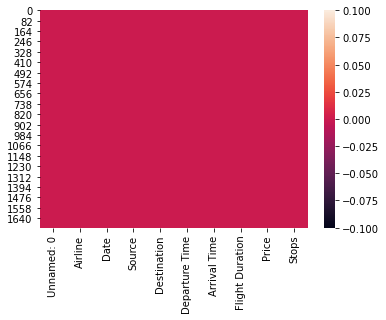

In [ ]:
sns.heatmap(df.isnull(), annot=False) #Visualization of null values

In [ ]:
df.columns #Calling all the column names of the dataset

Index(['Unnamed: 0', 'Airline', 'Date', 'Source', 'Destination',
       'Departure Time', 'Arrival Time', 'Flight Duration', 'Price', 'Stops'],
      dtype='object')

# Exploratory Data Analysis

We drop the unnamed column as it is just present as an index

In [ ]:
df.drop(columns='Unnamed: 0',inplace=True)

Let's look into each column independently   

<AxesSubplot:xlabel='Airline', ylabel='count'>

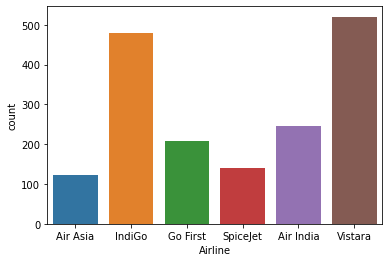

In [ ]:
#Column Airline
sns.countplot(df['Airline'])

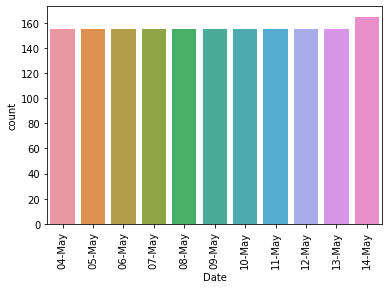

In [ ]:
#Column Date
plt.figure()
sns.countplot(df['Date'])
plt.xticks(rotation=90)
plt.show()

We see that the flights are for dates 04 to 14 for the month of May. We shall change it into date and month columns

In [ ]:
df['Day'] = pd.to_datetime(df['Date'], format='%d-%b').map(lambda x: x.day)
df['Month'] = pd.to_datetime(df['Date'], format='%d-%b').map(lambda x: x.month)

Now that we have converted the Date, we shall drop the date column

In [ ]:
df.drop(columns='Date',inplace=True)

In [ ]:
#Column Source
df['Source'].value_counts()

New Delhi    1715
Name: Source, dtype: int64

In [ ]:
#Column Destination
df['Destination'].value_counts()

Mumbai    1715
Name: Destination, dtype: int64

We see that the data is for flights from delhi to Mumbai

In [ ]:
#Column Departure Time
df['Departure Time'].value_counts()

14:45    52
12:50    46
17:35    43
7:20     42
20:35    40
         ..
16:55     1
20:15     1
14:50     1
12:35     1
17:25     1
Name: Departure Time, Length: 128, dtype: int64

We see that the time is in hours and minutes, let us create columns for it

In [ ]:
df['D_Hour'] = pd.to_datetime(df['Departure Time'], format='%H:%M').map(lambda x: x.hour)
df['D_Min'] = pd.to_datetime(df['Departure Time'], format='%H:%M').map(lambda x: x.minute)

Now that we have converted the Date, we shall drop the Departure Time column

In [ ]:
df.drop(columns='Departure Time',inplace=True)

In [ ]:
#Column Arrival Time
df['Arrival Time'].value_counts()

10:00\n+ 1 day    44
08:40\n+ 1 day    44
19:15             28
20:45             28
23:00             27
                  ..
10:25              1
23:50\n+ 1 day     1
23:10              1
00:25\n+ 1 day     1
11:00\n+ 1 day     1
Name: Arrival Time, Length: 160, dtype: int64

Since we have +1 day in the duration column, we shall just filter it out and leave with only time

In [ ]:
df['Arrival Time'] = df['Arrival Time'].map(lambda x: x.split('\n')[0])

We see that the time is in hours and minutes, let us create columns for it

In [ ]:
df['A_Hour'] = pd.to_datetime(df['Arrival Time'], format='%H:%M').map(lambda x: x.hour)
df['A_Min'] = pd.to_datetime(df['Arrival Time'], format='%H:%M').map(lambda x: x.minute)

Now that we have converted the Date, we shall drop the Arrival Time column

In [ ]:
df.drop(columns='Arrival Time',inplace=True)

In [ ]:
#Column Flight Duration
df['Flight Duration'].value_counts()

2h 10m     187
2h 15m     161
2h 05m      74
2h 20m      74
7h 15m      35
          ... 
16h 05m      1
8h 05m       1
15h 45m      1
17h 20m      1
17h 15m      1
Name: Flight Duration, Length: 148, dtype: int64

For ease let us just convert the column into minutes

In [ ]:
df['Flight Duration'] = df['Flight Duration'].map(lambda x: int(x.split('h')[0])*60 + int(x.split('h')[1][:-1]))

<AxesSubplot:xlabel='Flight Duration', ylabel='Density'>

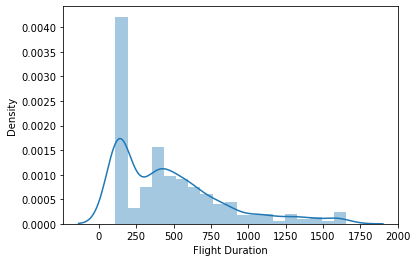

In [ ]:
sns.distplot(df['Flight Duration'])

In [ ]:
#Column Stops
df['Stops'].value_counts()

1 Stop       1111
Non Stop      579
2 Stop(s)      25
Name: Stops, dtype: int64

We shall change it into more understanding numerical type data for ease of modelling

In [ ]:
df['Stops'] = df['Stops'].map(lambda x: x.split('Stop')[0])

In [ ]:
df['Stops'] = df['Stops'].replace('Non ',0)

In [ ]:
df['Stops'] = df['Stops'].astype(int)

In [ ]:
df['Stops'].value_counts()

1    1111
0     579
2      25
Name: Stops, dtype: int64

In [ ]:
#Column Price
df['Price'].value_counts()

7,319     412
7,320     169
12,045    101
8,371      61
10,889     58
         ... 
13,042      1
16,632      1
16,228      1
12,779      1
16,415      1
Name: Price, Length: 233, dtype: int64

The commas present in the price makes it object type, let us treat it to convert into numerical type

In [ ]:
df['Price'] = df['Price'].map(lambda x: int(x.replace(',','')))

<AxesSubplot:xlabel='Price', ylabel='Density'>

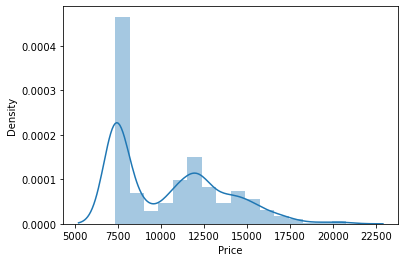

In [ ]:
sns.distplot(df['Price'])

# Data Analysis

In [ ]:
#General Airline basis analysis
pd.pivot_table(data=df,index=['Airline'])

,A_Hour,A_Min,D_Hour,D_Min,Day,Flight Duration,Month,Price,Stops
Airline,,,,,,,,,
Air Asia,16.778689,25.040984,14.368852,25.532787,9.196721,356.557377,5,9680.737705,0.516393
Air India,13.430894,25.711382,13.390244,27.215447,8.743902,527.764228,5,10610.951220,0.735772
Go First,13.600962,24.014423,12.403846,28.413462,8.980769,295.889423,5,9031.447115,0.326923
IndiGo,13.255230,27.207113,12.384937,27.876569,9.142259,455.230126,5,10529.150628,0.721757
SpiceJet,14.418440,23.049645,13.843972,28.226950,8.829787,335.673759,5,9114.985816,0.390071
Vistara,13.490385,23.480769,13.103846,27.769231,9.094231,600.442308,5,11515.855769,0.863462


We here see that on an average 'Go First' flights are cheaper followed by 'SpiceJet'

In [ ]:
#General Day basis analysis
pd.pivot_table(data=df,index=['Day'])

,A_Hour,A_Min,D_Hour,D_Min,Flight Duration,Month,Price,Stops
Day,,,,,,,,
4,14.219355,24.838710,13.161290,27.096774,516.451613,5,11164.348387,0.683871
5,13.748387,24.322581,12.567742,27.387097,476.548387,5,10602.638710,0.690323
6,13.348387,24.580645,12.787097,27.354839,476.838710,5,10145.083871,0.677419
7,13.561290,24.129032,12.748387,27.838710,435.258065,5,10427.148387,0.651613
8,13.412903,25.129032,13.309677,27.709677,505.290323,5,11298.909677,0.670968
9,13.670968,26.225806,12.690323,28.387097,446.870968,5,10258.219355,0.677419
10,14.322581,25.225806,13.845161,27.580645,527.967742,5,10879.400000,0.735484
11,13.548387,25.290323,13.051613,28.419355,463.322581,5,9911.561290,0.651613
12,13.425806,24.483871,12.838710,27.774194,459.290323,5,9673.458065,0.670968


Since the data scraping was done on 3rd May, we can analyse that flights are cheapest if booked approximately 9 days before the departure

In [ ]:
#General Time basis analysis
pd.pivot_table(data=df,index=['D_Hour'])

,A_Hour,A_Min,D_Min,Day,Flight Duration,Month,Price,Stops
D_Hour,,,,,,,,
0,7.333333,26.666667,15.000000,9.500000,451.666667,5,11905.933333,1.000000
2,4.000000,28.000000,18.000000,9.450000,130.000000,5,7319.000000,0.000000
4,8.240000,40.800000,37.400000,9.400000,257.800000,5,10034.320000,0.560000
5,12.428571,25.357143,29.948980,9.000000,441.122449,5,10238.663265,1.000000
6,13.298701,19.415584,16.493506,8.285714,440.844156,5,11399.285714,0.597403
7,12.538462,29.230769,16.875000,9.076923,372.355769,5,10018.682692,0.490385
8,13.414286,21.785714,22.571429,8.928571,324.071429,5,9408.342857,0.385714
9,16.584071,28.672566,30.221239,8.911504,504.469027,5,11243.292035,0.823009
10,13.513889,25.312500,30.486111,8.736111,605.659722,5,10443.055556,0.847222


From this data we see that flight with departure around midnight is the cheapest

In [ ]:
#General Stops basis analysis
pd.pivot_table(data=df,index=['Stops'])

,A_Hour,A_Min,D_Hour,D_Min,Day,Flight Duration,Month,Price
Stops,,,,,,,,
0,14.297064,23.886010,13.405872,26.994819,9.043178,132.435233,5,7578.918826
1,13.363636,25.729073,12.892889,28.001800,9.031503,650.706571,5,12032.686769
2,17.560000,17.000000,9.080000,29.000000,8.600000,496.800000,5,8790.720000


For Delhi-Mumbai flight, non-stop flights are comparitively cheaper. Let us look for patter in the flight duration to confirm

In [ ]:
#General Duration basis analysis
pd.pivot_table(data=df,index=['Flight Duration'])

,A_Hour,A_Min,D_Hour,D_Min,Day,Month,Price,Stops
Flight Duration,,,,,,,,
110,14.000000,50.000000,13.000000,0.000000,8.900000,5,7350.600000,0.0
120,14.750000,28.125000,12.750000,28.125000,9.093750,5,7890.593750,0.0
125,10.108108,27.972973,11.351351,22.972973,9.108108,5,7424.270270,0.0
130,14.802139,28.315508,12.732620,22.486631,9.096257,5,7513.684492,0.0
135,15.012422,21.397516,14.409938,29.875776,9.006211,5,7670.155280,0.0
...,...,...,...,...,...,...,...,...
1585,23.000000,0.000000,20.000000,35.000000,9.625000,5,12333.750000,1.0
1595,0.000000,35.000000,22.000000,0.000000,9.000000,5,12226.363636,1.0
1600,16.000000,0.000000,13.000000,20.000000,9.000000,5,11820.000000,1.0


This above data confirms that non stop flights are comparitively cheaper

# Correlation

Before we move to correlation matrix, let us encode the object data types

In [ ]:
le = LabelEncoder()
df['Airline'] = le.fit_transform(df['Airline'])
df['Source'] = le.fit_transform(df['Source'])
df['Destination'] = le.fit_transform(df['Destination'])

In [ ]:
#Checking the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Airline          1715 non-null   int32
 1   Source           1715 non-null   int32
 2   Destination      1715 non-null   int32
 3   Flight Duration  1715 non-null   int64
 4   Price            1715 non-null   int64
 5   Stops            1715 non-null   int32
 6   Day              1715 non-null   int64
 7   Month            1715 non-null   int64
 8   D_Hour           1715 non-null   int64
 9   D_Min            1715 non-null   int64
 10  A_Hour           1715 non-null   int64
 11  A_Min            1715 non-null   int64
dtypes: int32(4), int64(8)
memory usage: 134.1 KB


In [ ]:
#Statistical description of the data
df.describe()

,Airline,Source,Destination,Flight Duration,Price,Stops,Day,Month,D_Hour,D_Min,A_Hour,A_Min
count,1715.000000,1715.0,1715.0,1715.000000,1715.000000,1715.000000,1715.000000,1715.0,1715.000000,1715.000000,1715.000000,1715.000000
mean,3.067055,0.0,0.0,473.489796,10481.794169,0.676968,9.029155,5.0,13.010496,27.676385,13.739942,24.979592
std,1.620912,0.0,0.0,365.008343,3143.484340,0.497977,3.176869,0.0,5.712267,17.723657,6.593817,17.545977
min,0.000000,0.0,0.0,110.000000,7319.000000,0.000000,4.000000,5.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.0,0.0,135.000000,7320.000000,0.000000,6.000000,5.0,9.000000,15.000000,9.000000,10.000000
50%,3.000000,0.0,0.0,405.000000,10364.000000,1.000000,9.000000,5.0,13.000000,30.000000,14.000000,25.000000
75%,5.000000,0.0,0.0,635.000000,12570.000000,1.000000,12.000000,5.0,18.000000,45.000000,20.000000,40.000000
max,5.000000,0.0,0.0,1655.000000,20760.000000,2.000000,14.000000,5.0,23.000000,55.000000,23.000000,55.000000


From the above data we note that there are few outliers present in the data

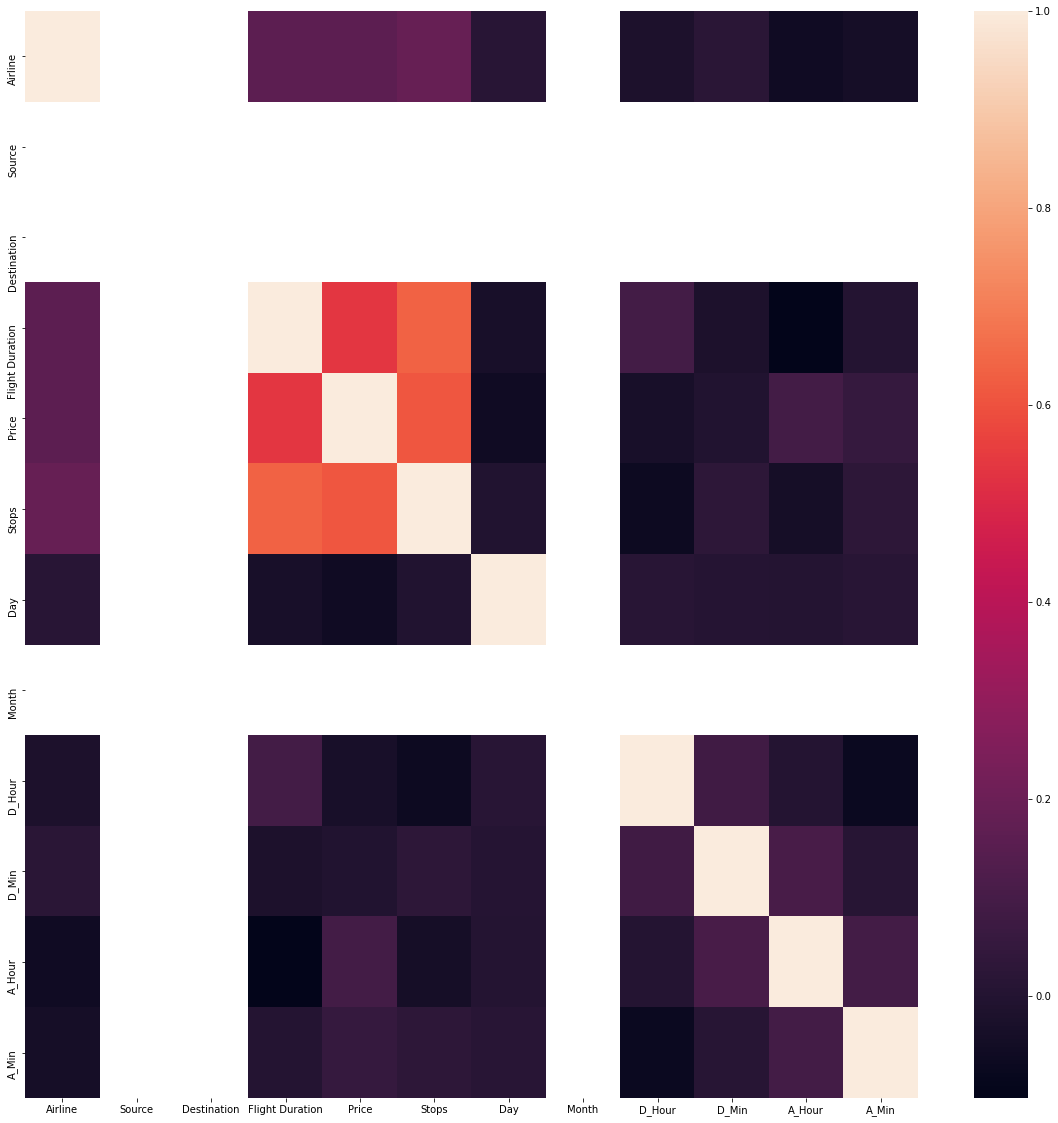

In [ ]:
#Correlation Matrix
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=False)
plt.show()

In [ ]:
#Data correlation wrt target variable
df.corr()['Price']

Airline            0.161910
Source                  NaN
Destination             NaN
Flight Duration    0.536377
Price              1.000000
Stops              0.610677
Day               -0.057788
Month                   NaN
D_Hour            -0.031721
D_Min             -0.008052
A_Hour             0.093231
A_Min              0.055315
Name: Price, dtype: float64

We see that the Stops, Airline and the Duration gives maximum positive correlation to the target column

We also note that columns Source, Destination, Month does not produce any correlation as the values are same for all the rows and hence we shall drop them for model purpose

In [ ]:
df.drop(columns=['Source','Destination','Month'],inplace=True)

# Outliers

We treat for outliers using zscore method

In [ ]:
z = np.abs(zscore(df))

We take a zscore threshold of range(-3,3)

In [ ]:
df2 = df[(z<3).all(axis=1)]

In [ ]:
print("Percentage loss of data:\t", ((df.shape[0]-df2.shape[0])*100)/df.shape[0], "%")

Percentage loss of data:	 2.565597667638484 %


# Skewness

Before we move forward, let us first split the dataset into target and feature variables

In [ ]:
x = df2.drop(columns='Price')
y = df2['Price']

In [ ]:
#Checking for skewness
x.skew()

Airline           -0.274946
Flight Duration    1.069062
Stops             -0.356286
Day               -0.004581
D_Hour            -0.115926
D_Min             -0.196102
A_Hour            -0.357772
A_Min              0.108873
dtype: float64

We treat for skewness only those columns which have more than 0.4

In [ ]:
#Treating for skewness using log method
for i in x.columns:
    if(np.abs(x[i].skew())>0.4):
        x[i] = np.log1p(x[i])

In [ ]:
#Checking for skewness after treating data
x.skew()

Airline           -0.274946
Flight Duration   -0.000536
Stops             -0.356286
Day               -0.004581
D_Hour            -0.115926
D_Min             -0.196102
A_Hour            -0.357772
A_Min              0.108873
dtype: float64

# Scaling

We use standard scaler for scaling data

In [ ]:
sc = StandardScaler()
x = sc.fit_transform(x)

# Best Random State

In [ ]:
maxRS = 0
maxAcc = 0
for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=i)
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    pred = lr.predict(x_test)
    acc = r2_score(y_test, pred)
    if acc>maxAcc:
        maxAcc = acc
        maxRS = i
print("Max accuracy: \t", maxAcc)
print("Random State: \t", maxRS)

Max accuracy: 	 0.5621300155717905
Random State: 	 55


Now since we got the best random state for data modelling, we create the test train models

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=maxRS)

# Model Predictions

Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(x_train,y_train)
pred = lr.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 56.213001557179055
Mean Square Error : 	 4131211.693320779
Root Mean Square Error : 	 2032.5382390795946


KNN Regressor

In [ ]:
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)
pred = knn.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 59.69360721747765
Mean Square Error : 	 3802823.8312835824
Root Mean Square Error : 	 1950.083031894689


SUPPORT VECTOR MACHINES

In [ ]:
svr = SVR()
svr.fit(x_train,y_train)
pred = svr.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 -0.9670391374581033
Mean Square Error : 	 9526028.902605254
Root Mean Square Error : 	 3086.426558757758


Random Forest Regressor

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 78.72458355055069
Mean Square Error : 	 2007291.0302588851
Root Mean Square Error : 	 1416.7889857910686


Decision Tree Regressor

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
pred = dt.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 58.117655202752715
Mean Square Error : 	 3951511.6067164177
Root Mean Square Error : 	 1987.840941000164


XGB Regressor

In [ ]:
xgb = XGBRegressor()
xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 79.75484161549666
Mean Square Error : 	 1910088.3373042454
Root Mean Square Error : 	 1382.059455054031


Out of all the models Random Forest Regressor and XGB Regressor has the highest r2_score

# Cross validation

In [ ]:
scr1 = cross_val_score(lr, x, y, cv=5, scoring='r2')
print("Cross validation score of Linear Regression is: \t", scr1.mean())

Cross validation score of Linear Regression is: 	 0.438010077534529


In [ ]:
scr2 = cross_val_score(dt, x, y, cv=5)
print("Cross validation score of Decision Tree Regressor is: \t", scr2.mean())

Cross validation score of Decision Tree Regressor is: 	 0.43022740441871055


In [ ]:
scr3 = cross_val_score(rf, x, y, cv=5)
print("Cross validation score of Random Forest Regressor is: \t", scr3.mean())

Cross validation score of Random Forest Regressor is: 	 0.6941343208424116


In [ ]:
scr4 = cross_val_score(knn, x, y, cv=5)
print("Cross validation score of KNeighbour Regressor is: \t", scr4.mean())

Cross validation score of KNeighbour Regressor is: 	 0.5046699406830102


In [ ]:
scr5 = cross_val_score(svr, x, y, cv=5)
print("Cross validation score of SVM is: \t", scr5.mean())

Cross validation score of SVM is: 	 0.01104988909700928


In [ ]:
scr6 = cross_val_score(xgb, x, y, cv=5)
print("Cross validation score of XGB is: \t", scr6.mean())

Cross validation score of XGB is: 	 0.6527216003906042


We see that the Random Forest Regressor performs the best in cross validation

# Hyper Parameter Tuning

In [ ]:
GridSearchCV.get_params(rf)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
parameters = {'bootstrap': [True,False],
              'max_depth': [10, 20, None],
              'min_samples_leaf': [1,2,4],
              'min_samples_split': [2,5,10],
              'n_estimators': [100,200]}

In [ ]:
gcv = GridSearchCV(rf, parameters, cv=5, scoring='r2')

In [ ]:
gcv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [ ]:
print("Tuned Hyperparameters :", gcv.best_params_)
print("Accuracy :",gcv.best_score_)

Tuned Hyperparameters : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy : 0.7299605271182121


In [ ]:
gcv_pred = gcv.best_estimator_.predict(x_test)
r2_score(y_test,gcv_pred)

0.7829653041916005

The best estimator gives the accuracy of 78.29% and hence we shall save previous model.

# Saving the best model

In [ ]:
joblib.dump(rf,"Flight_Price.pkl")

['Flight_Price.pkl']